**TODO: put (parts of) this into paper and/or README.**

How parameter tuning works in our case:

Each evaluator has one or two numerical parameters that can be "tuned" in order to minimize a certain error. However, we have no mathematical model that can be trained in the classical ML sense. Instead, for every service, we try parameters from a parameter grid and consider this as "training" or "tuning".

We train the parameters using a 5-fold cross validation and report the average error on the test sets as the optimal error that can be achieved.

To make the tuning comparable across services, we build the parameter grids based on quantiles of the distributions of the tuning parameters. For every service and parameter we use a maximum of 20 parameter values as a default. (Note that depending on the distribution the number of the resulting parameter values can be less than 20.) For this step we consider only those responses where the API/service decided for 'f' or 'm' (so we ignore 'unknown' or similar). 

Finally, we train each evaluator on the entire data set to obtain the best parameter values for a given error.

In [1]:
import pandas as pd
import numpy as np
from evaluators import *
from evaluator import *
from helpers import REGISTERED_EVALUATORS, compute_equal_frequency_binning

import matplotlib.ticker as mtick
from mpltools import style
style.use('ggplot')
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import ParameterSampler

import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/helena.mihaljevic-br/.virtualenvs/name-based-inference/lib/python3.5/site-packages/mpltools/style/__init__.py:42: FutureWarning: 

    The style-sheet functionality in mpltools has been integrated into
    Matplotlib >= 1.4. This module will be removed in a future release.

    Note that style-sheets used by `matplotlib.style` use the standard
    Matplotlib rc-file syntax instead of the INI format used by `mpltools`.
    This mostly means un-quoting strings and changing '=' to ':'.


  """, FutureWarning)
/Users/helena.mihaljevic-br/.virtualenvs/name-based-inference/lib/python3.5/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)
/Users/helena.mihaljevic-br/.virtualenvs/name-based-inference/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['shuffle', 'style']
`%matplotlib` prevents i

## Compute errors without tuning

In [2]:
def compute_all_errors_without_tuning():
    service_to_all_errors = {}
    error_names = ['error_with_unknown', 'error_without_unknown', 'error_gender_bias', 'error_unknown', 
                  'weighted_error','f_precision', 'f_recall']
    
    for s in REGISTERED_EVALUATORS:  
        evaluator = s('all')
        eval_name = evaluator.gender_evaluator
        evaluator.load_data(evaluated=True)
        evaluator._translate_api_response()
        evaluator.compute_confusion_matrix(evaluator.test_data)
        errors = evaluator.compute_all_errors()
        service_to_all_errors[eval_name] = errors
    all_errors = pd.DataFrame.from_dict(service_to_all_errors, orient='index')
    all_errors.columns = error_names
    return all_errors

In [3]:
error_names_all = ['error_with_unknown', 'error_without_unknown', 'error_gender_bias', 'error_unknown', 
                  'weighted_error','f_precision', 'f_recall']
error_names_selected = ['error_with_unknown', 'error_without_unknown', 'error_unknown', 'weighted_error']

In [4]:
compute_all_errors_without_tuning()

,error_with_unknown,error_without_unknown,error_gender_bias,error_unknown,weighted_error,f_precision,f_recall
namsor,0.135924,0.051384,0.010049,0.089119,0.069590,0.911184,0.938453
gender_guesser,0.229361,0.035243,0.005405,0.201209,0.081515,0.941360,0.956274
genderize_io,0.150432,0.058925,0.025253,0.097237,0.078770,0.886715,0.951381
gender_api,0.086701,0.058405,-0.008191,0.030052,0.064203,0.924559,0.902350
names_api,0.237997,0.050161,0.010549,0.197755,0.094789,0.918308,0.945140
gender_api_full,0.204145,0.077108,-0.019027,0.137651,0.105659,0.911043,0.860870
names_api_full,0.186874,0.043284,0.007112,0.150086,0.075921,0.927865,0.947150


In [5]:
# maybe this for the paper
cm = sns.light_palette("green", as_cmap=True)
df = compute_all_errors_without_tuning()
df = df[error_names_selected]

df.style.background_gradient(cmap=cm)

,error_with_unknown,error_without_unknown,error_unknown,weighted_error
namsor,0.135924,0.0513841,0.0891192,0.0695901
gender_guesser,0.229361,0.0352432,0.201209,0.081515
genderize_io,0.150432,0.0589248,0.0972366,0.0787699
gender_api,0.0867012,0.0584046,0.0300518,0.0642033
names_api,0.237997,0.0501615,0.197755,0.0947887
gender_api_full,0.204145,0.077108,0.137651,0.105659
names_api_full,0.186874,0.0432839,0.150086,0.0759205


## Plot distributions of the tuning parameters

Seaborn does not work with matplotlib subplots and its own grids are not applicable here. Matplotlib on the other hand has no good plots of bivariate distributions. Hence plotting each of the seven distributions separately...

In [6]:
def plot_distribution_of_tuning_param(e):
    evaluator = e('all')
    evaluator.load_data(evaluated=True)
    evaluator.preprocess_data_for_parameter_tuning()
    evaluator._translate_api_response()
    evaluator.remove_rows_with_unknown_gender(gender=False, gender_infered=True)
    
    tuning_params = list(evaluator.tuning_params)
    if len(tuning_params) == 1:
        sns.distplot(evaluator.test_data[tuning_params], kde=False)
    else:
        param_1, param_2 = tuning_params[0], tuning_params[1]
        sns.jointplot(x=param_1, y=param_2, data=evaluator.test_data[tuning_params])

gender_api


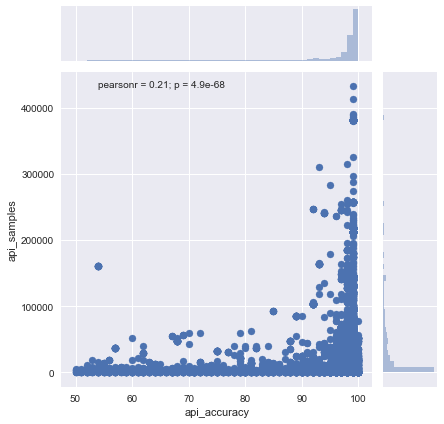

In [7]:
e = REGISTERED_EVALUATORS[0]
print(e.gender_evaluator)
plot_distribution_of_tuning_param(e)

gender_api_full


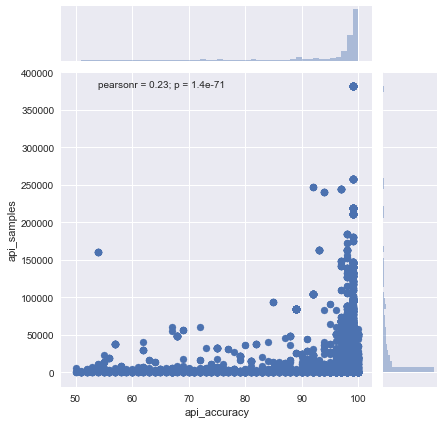

In [8]:
e = REGISTERED_EVALUATORS[1]
print(e.gender_evaluator)
plot_distribution_of_tuning_param(e)

names_api


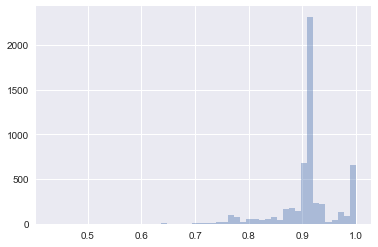

In [9]:
e = REGISTERED_EVALUATORS[2]
print(e.gender_evaluator)
plot_distribution_of_tuning_param(e)

names_api_full


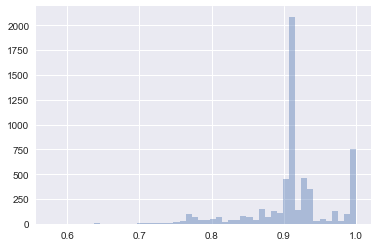

In [10]:
e = REGISTERED_EVALUATORS[3]
print(e.gender_evaluator)
plot_distribution_of_tuning_param(e)

namsor


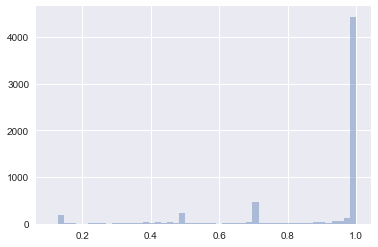

In [11]:
e = REGISTERED_EVALUATORS[4]
print(e.gender_evaluator)
plot_distribution_of_tuning_param(e)

gender_guesser


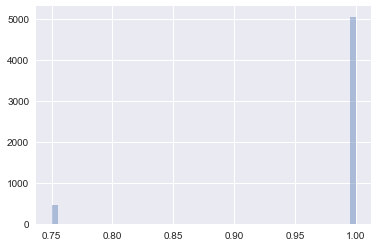

In [12]:
e = REGISTERED_EVALUATORS[5]
print(e.gender_evaluator)
plot_distribution_of_tuning_param(e)

genderize_io


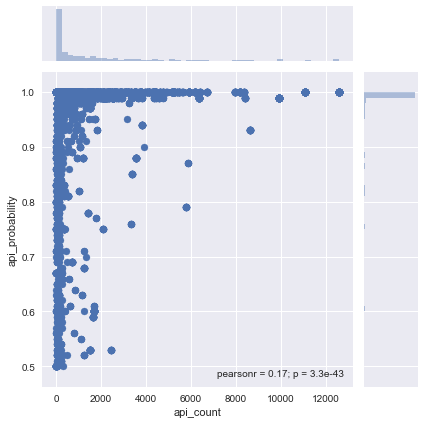

In [13]:
e = REGISTERED_EVALUATORS[6]
print(e.gender_evaluator)
plot_distribution_of_tuning_param(e)

## Discretize distribution of tuning parameters via random sampling

Example from scikit-learn docstring

In [14]:
from scipy.stats.distributions import expon
import numpy as np
np.random.seed(0)
param_grid = {'a':[1, 2], 'b': expon()}
param_list = list(ParameterSampler(param_grid, n_iter=4))
rounded_list = [dict((k, round(v, 6)) for (k, v) in d.items()) for d in param_list]

rounded_list

[{'a': 1, 'b': 0.89856000000000003},
 {'a': 1, 'b': 0.92322300000000002},
 {'a': 2, 'b': 1.8789640000000001},
 {'a': 2, 'b': 1.0381590000000001}]

## Build parameter grids for all services

In [15]:
def build_parameter_grid(e, n_iter=20, method='square', random_state=None):
    """method is either 'square' or 'constant'"""
    tuning_params = list(e.tuning_params)

    param_grid = {}
    for param in tuning_params:
        param_grid[param] = e.test_data[param].values
    
    if method=='square':
        n_params = n_iter**len(tuning_params)
    else:
        n_params=n_iter

    param_list = list(ParameterSampler(param_grid, n_iter=n_params, random_state=random_state))
    zero_el = {k:0 for k in param_list[0].keys()}
    param_list = [dict(t) for t in set([tuple(d.items()) for d in param_list])] + [zero_el] # deduplicate and add zero element
    param_grid = [dict((k, round(v, 6)) for (k, v) in d.items()) for d in param_list]
    
    return param_grid


In [16]:
s = REGISTERED_EVALUATORS[0]
evaluator = s('all')
eval_name = evaluator.gender_evaluator
evaluator.load_data(evaluated=True)
evaluator.preprocess_data_for_parameter_tuning()
evaluator._translate_api_response()
evaluator.remove_rows_with_unknown_gender(gender=False, gender_infered=True)

build_parameter_grid(evaluator, n_iter=3)

[{'api_accuracy': 98, 'api_samples': 131879},
 {'api_accuracy': 97, 'api_samples': 23277},
 {'api_accuracy': 99, 'api_samples': 9249},
 {'api_accuracy': 98, 'api_samples': 8496},
 {'api_accuracy': 99, 'api_samples': 5178},
 {'api_accuracy': 51, 'api_samples': 16800},
 {'api_accuracy': 65, 'api_samples': 38223},
 {'api_accuracy': 95, 'api_samples': 2917},
 {'api_accuracy': 81, 'api_samples': 3281},
 {'api_accuracy': 0, 'api_samples': 0}]

In [17]:
def build_grid_for_all_services(n_iter=20, method='square', random_state=None):
    service_to_grid_range = {}
    for s in REGISTERED_EVALUATORS:  
        evaluator = s('all')
        evaluator.load_data(evaluated=True)
        evaluator.preprocess_data_for_parameter_tuning()
        evaluator._translate_api_response()
        evaluator.remove_rows_with_unknown_gender(gender=False, gender_infered=True)
        
        service_to_grid_range[evaluator.gender_evaluator] = build_parameter_grid(evaluator, n_iter=n_iter, 
                                                                                 method=method, random_state=random_state)
        
    return service_to_grid_range

In [18]:
grid_20_20 = build_grid_for_all_services(n_iter=20, method="constant")
grid_30_30 = build_grid_for_all_services(n_iter=30, method="constant")
grid_50_50 = build_grid_for_all_services(n_iter=50, method="constant")
grid_100_100 = build_grid_for_all_services(n_iter=100, method="constant")
grid_200_200 = build_grid_for_all_services(n_iter=200, method="constant")

grid_20_400 = build_grid_for_all_services(n_iter=20, method="square")

In [19]:
# check size of grid per service
dict_of_grids = {"a: 20-20": grid_20_20, "b: 30-30": grid_30_30, "c: 50-50": grid_50_50, 
                             "d: 100-100": grid_100_100, "e: 200-200": grid_200_200, "f: 20-400": grid_20_400}

dict_of_grids = OrderedDict(sorted(dict_of_grids.items(), key=lambda t: t[0]))

for grid_size, service_to_grid in dict_of_grids.items():
    print(grid_size)
    for service, grid in service_to_grid.items():
        print(service, len(grid))

a: 20-20
namsor 7
gender_guesser 3
genderize_io 21
gender_api 21
names_api 12
gender_api_full 21
names_api_full 14
b: 30-30
namsor 10
gender_guesser 3
genderize_io 30
gender_api 31
names_api 17
gender_api_full 31
names_api_full 19
c: 50-50
namsor 13
gender_guesser 3
genderize_io 50
gender_api 50
names_api 26
gender_api_full 51
names_api_full 24
d: 100-100
namsor 17
gender_guesser 3
genderize_io 94
gender_api 100
names_api 48
gender_api_full 98
names_api_full 47
e: 200-200
namsor 30
gender_guesser 3
genderize_io 177
gender_api 195
names_api 78
gender_api_full 195
names_api_full 80
f: 20-400
namsor 6
gender_guesser 3
genderize_io 304
gender_api 380
names_api 17
gender_api_full 384
names_api_full 12


We see the following:

* for `gender_guesser` there are at most 3 parameter values anyway so exhaustive search of parameter space is reached
* the `namsor` parameter space is quite sparse, hence the grid size does not grow as fast; the other 1-parameter service `names_api` (and `names_api_full`) profits more
* the grid sizes for the 2-parameter services `gender_api` (and `gender_api_full`) and `genderize_io` grow almost to the limit of the allowed grid size

In [20]:
grid_20_20['gender_api']

[{'api_accuracy': 98, 'api_samples': 8},
 {'api_accuracy': 99, 'api_samples': 2098},
 {'api_accuracy': 99, 'api_samples': 68146},
 {'api_accuracy': 99, 'api_samples': 48539},
 {'api_accuracy': 57, 'api_samples': 32},
 {'api_accuracy': 66, 'api_samples': 3438},
 {'api_accuracy': 99, 'api_samples': 1516},
 {'api_accuracy': 80, 'api_samples': 154},
 {'api_accuracy': 98, 'api_samples': 5361},
 {'api_accuracy': 51, 'api_samples': 3076},
 {'api_accuracy': 98, 'api_samples': 216},
 {'api_accuracy': 99, 'api_samples': 2658},
 {'api_accuracy': 97, 'api_samples': 4804},
 {'api_accuracy': 99, 'api_samples': 48002},
 {'api_accuracy': 100, 'api_samples': 245074},
 {'api_accuracy': 98, 'api_samples': 11769},
 {'api_accuracy': 95, 'api_samples': 56140},
 {'api_accuracy': 100, 'api_samples': 146529},
 {'api_accuracy': 99, 'api_samples': 19676},
 {'api_accuracy': 99, 'api_samples': 2163},
 {'api_accuracy': 0, 'api_samples': 0}]

In [21]:
grid_20_20['gender_guesser']

[{'confidence': 1.0}, {'confidence': 0.75}, {'confidence': 0}]

### Test the effect of parameters for grid creation using one error function

#### We choose a smaller grid and repeat the evaluation n times

In [23]:
# Wrapper around some methods to make tuning with different error functions a one-liner
def prepare_for_tuning(e):
    e.load_data(evaluated=True)
    e.preprocess_data_for_parameter_tuning()
    e._translate_api_response()
    e.remove_rows_with_unknown_gender(gender=True, gender_infered=False)
    e.shuffle_data()
    return e

def tune(error_func, grids, constraint_func=None, constraint_val=None, verbose=True):
    service_to_test_error = {}
    for s in REGISTERED_EVALUATORS:  
        evaluator = s('all')
        evaluator_name = evaluator.gender_evaluator
        print(evaluator_name)

        evaluator = prepare_for_tuning(evaluator)
        
        grid = grids[evaluator_name]
        mean_test_error = evaluator.compute_cv_score(n_splits=5, param_grid=grid, error_func=error_func, 
                                                    constraint_func=constraint_func, constraint_val=constraint_val, 
                                                    verbose=verbose)
        service_to_test_error[evaluator_name] = mean_test_error
    return service_to_test_error

def tune_repeat(error_func, grid_size, n_repeat=10, constraint_func=None, constraint_val=None, verbose=False):
    list_of_service_to_test_error = []
    for i in range(n_repeat):
        grids = build_grid_for_all_services(n_iter=grid_size, method='constant', random_state=i)
        service_to_test_error = tune(error_func, grids, constraint_func=constraint_func, 
                                                  constraint_val=constraint_val, verbose=verbose)
        list_of_service_to_test_error.append(list(sorted(service_to_test_error.items(), key=lambda t: t[1])))
    return list_of_service_to_test_error
    

In [24]:
result = tune_repeat(error_func=Evaluator.compute_error_with_unknown, grid_size=30, n_repeat=10, 
                     constraint_func=Evaluator.compute_error_without_unknown, constraint_val=0.05, verbose=True)

gender_api
minimal train error: 0.127402288922 corresponding test error: 0.135461604832
params for lowest train error: {'api_samples': 3281, 'api_accuracy': 81}
minimal train error: 0.088298791019 corresponding test error: 0.080310880829
params for lowest train error: {'api_samples': 0, 'api_accuracy': 0}
minimal train error: 0.104706390328 corresponding test error: 0.115716753022
params for lowest train error: {'api_samples': 38223, 'api_accuracy': 65}
minimal train error: 0.0898100172712 corresponding test error: 0.0768566493955
params for lowest train error: {'api_samples': 32, 'api_accuracy': 57}
minimal train error: 0.100798618606 corresponding test error: 0.106309420916
params for lowest train error: {'api_samples': 3438, 'api_accuracy': 66}
Average test error: 0.102931061799
gender_api_full
minimal train error: 0.257179874757 corresponding test error: 0.270923209664
params for lowest train error: {'api_samples': 68146, 'api_accuracy': 78}
minimal train error: 0.26079447323 corre

minimal train error: 0.160224573526 corresponding test error: 0.173425366695
params for lowest train error: {'api_scale': 0.40999999999999998}
minimal train error: 0.14097582038 corresponding test error: 0.115716753022
params for lowest train error: {'api_scale': 0.13}
minimal train error: 0.135362694301 corresponding test error: 0.13816925734
params for lowest train error: {'api_scale': 0.13}
minimal train error: 0.160837651123 corresponding test error: 0.170984455959
params for lowest train error: {'api_scale': 0.40999999999999998}
minimal train error: 0.161882149795 corresponding test error: 0.166810717373
params for lowest train error: {'api_scale': 0.40999999999999998}
Average test error: 0.153021310078
gender_guesser
minimal train error: 0.228460375729 corresponding test error: 0.2329594478
params for lowest train error: {'confidence': 0.75}
minimal train error: 0.227547495682 corresponding test error: 0.236614853195
params for lowest train error: {'confidence': 0.75}
minimal tra

minimal train error: 0.262794212913 corresponding test error: 0.276962899051
params for lowest train error: {'api_samples': 44680, 'api_accuracy': 80}
minimal train error: 0.26597582038 corresponding test error: 0.258203799655
params for lowest train error: {'api_samples': 11999, 'api_accuracy': 81}
minimal train error: 0.265544041451 corresponding test error: 0.259930915371
params for lowest train error: {'api_samples': 11999, 'api_accuracy': 81}
minimal train error: 0.260362694301 corresponding test error: 0.280656303972
params for lowest train error: {'api_samples': 11999, 'api_accuracy': 81}
minimal train error: 0.267860997194 corresponding test error: 0.250648228176
params for lowest train error: {'api_samples': 11999, 'api_accuracy': 81}
Average test error: 0.265280429245
names_api
minimal train error: 0.928093284388 corresponding test error: 0.933563416739
params for lowest train error: {'api_confidence': 1.0}
minimal train error: 0.24481865285 corresponding test error: 0.210708

minimal train error: 0.232081174439 corresponding test error: 0.218480138169
params for lowest train error: {'confidence': 0.75}
minimal train error: 0.229058721934 corresponding test error: 0.230569948187
params for lowest train error: {'confidence': 0.75}
minimal train error: 0.229656809842 corresponding test error: 0.228176318064
params for lowest train error: {'confidence': 0.75}
Average test error: 0.229360141083
genderize_io
minimal train error: 0.212697041676 corresponding test error: 0.246764452114
params for lowest train error: {'api_probability': 0.95999999999999996, 'api_count': 460.0}
minimal train error: 0.153281519862 corresponding test error: 0.139032815199
params for lowest train error: {'api_probability': 0, 'api_count': 0}
minimal train error: 0.210276338515 corresponding test error: 0.218480138169
params for lowest train error: {'api_probability': 1.0, 'api_count': 80.0}
minimal train error: 0.153281519862 corresponding test error: 0.145941278066
params for lowest tr

minimal train error: 0.24481865285 corresponding test error: 0.210708117444
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.235535405872 corresponding test error: 0.247841105354
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.240716753022 corresponding test error: 0.227115716753
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.2369954673 corresponding test error: 0.242005185825
params for lowest train error: {'api_confidence': 0}
Average test error: 0.372246708423
names_api_full
minimal train error: 0.183761606564 corresponding test error: 0.199309749784
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.192141623489 corresponding test error: 0.165803108808
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.184153713299 corresponding test error: 0.197754749568
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.189550949914 corresp

minimal train error: 0.178972366149 corresponding test error: 0.194300518135
params for lowest train error: {'api_probability': 0.82999999999999996, 'api_count': 192.0}
minimal train error: 0.153281519862 corresponding test error: 0.145941278066
params for lowest train error: {'api_probability': 1.0, 'api_count': 3.0}
minimal train error: 0.160802935463 corresponding test error: 0.160760587727
params for lowest train error: {'api_probability': 0.58999999999999997, 'api_count': 1631.0}
Average test error: 0.167523864674
gender_api
minimal train error: 0.148779961132 corresponding test error: 0.157031924072
params for lowest train error: {'api_samples': 3874, 'api_accuracy': 89}
minimal train error: 0.088298791019 corresponding test error: 0.080310880829
params for lowest train error: {'api_samples': 0, 'api_accuracy': 0}
minimal train error: 0.148316062176 corresponding test error: 0.158894645941
params for lowest train error: {'api_samples': 3874, 'api_accuracy': 89}
minimal train erro

minimal train error: 0.192141623489 corresponding test error: 0.165803108808
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.184153713299 corresponding test error: 0.197754749568
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.189550949914 corresponding test error: 0.176165803109
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.184761493633 corresponding test error: 0.195332757131
params for lowest train error: {'api_confidence': 0}
Average test error: 0.18687323368
namsor
minimal train error: 0.174476354999 corresponding test error: 0.183779119931
params for lowest train error: {'api_scale': 0.5}
minimal train error: 0.14097582038 corresponding test error: 0.115716753022
params for lowest train error: {'api_scale': 0}
minimal train error: 0.135362694301 corresponding test error: 0.13816925734
params for lowest train error: {'api_scale': 0}
minimal train error: 0.17530224525 corresponding test error: 0.1

In [25]:
result[0]

[('gender_api', 0.1029310617989783),
 ('namsor', 0.14870351821002115),
 ('genderize_io', 0.17217903015093641),
 ('names_api_full', 0.18687323368002523),
 ('gender_guesser', 0.22936014108294717),
 ('gender_api_full', 0.25992651799535443),
 ('names_api', 0.38553402507527212)]

In [26]:
from collections import Counter

In [28]:
first_service, second_service = [], []
for item in result:
    print(item[0], item[1])
    first_service.append(item[0][0])
    second_service.append(item[1][0])
    
print(Counter(first_service), Counter(second_service))

('gender_api', 0.1029310617989783) ('namsor', 0.14870351821002115)
('gender_api', 0.10276356919724913) ('namsor', 0.15302131007783712)
('gender_api', 0.10604061672344134) ('namsor', 0.14922180220038989)
('gender_api', 0.10500240954745929) ('namsor', 0.16062196580075622)
('gender_api', 0.10224170620495883) ('namsor', 0.15336703177187344)
('gender_api', 0.12020804276562636) ('namsor', 0.16062196580075622)
('gender_api', 0.11622851681009794) ('namsor', 0.16062196580075622)
('gender_api', 0.1053512613870152) ('namsor', 0.15958494999399014)
('gender_api', 0.12641969271131018) ('namsor', 0.15526745667685987)
('gender_api', 0.12762167116677731) ('namsor', 0.16062196580075622)
Counter({'gender_api': 10}) Counter({'namsor': 10})


In [29]:
data = [{i[0]:i[1] for i in item} for item in result]
df = pd.DataFrame.from_dict(data)

In [30]:
df

,gender_api,gender_api_full,gender_guesser,genderize_io,names_api,names_api_full,namsor
0,0.102931,0.259927,0.22936,0.172179,0.385534,0.186873,0.148704
1,0.102764,0.271153,0.22936,0.169254,0.372247,0.186873,0.153021
2,0.106041,0.251114,0.22936,0.168904,0.372247,0.186873,0.149222
3,0.105002,0.265280,0.22936,0.167527,0.372247,0.186873,0.160622
4,0.102242,0.259581,0.22936,0.182369,0.372247,0.186873,0.153367
5,0.120208,0.277543,0.22936,0.166487,0.372247,0.186873,0.160622
6,0.116229,0.260958,0.22936,0.163723,0.372247,0.186873,0.160622
7,0.105351,0.270974,0.22936,0.167524,0.372247,0.186873,0.159585
8,0.126420,0.256988,0.22936,0.172185,0.372247,0.186873,0.155267
9,0.127622,0.248698,0.22936,0.170290,0.385534,0.186873,0.160622


In [32]:
df.describe()

,gender_api,gender_api_full,gender_guesser,genderize_io,names_api,names_api_full,namsor
count,10.000000,10.000000,1.000000e+01,10.000000,10.000000,10.000000,10.000000
mean,0.111481,0.262222,2.293601e-01,0.170044,0.374904,0.186873,0.156165
std,0.010143,0.009116,2.925695e-17,0.005037,0.005602,0.000000,0.004871
min,0.102242,0.248698,2.293601e-01,0.163723,0.372247,0.186873,0.148704
25%,0.103449,0.257636,2.293601e-01,0.167525,0.372247,0.186873,0.153108
50%,0.105696,0.260442,2.293601e-01,0.169079,0.372247,0.186873,0.157426
75%,0.119213,0.269551,2.293601e-01,0.171707,0.372247,0.186873,0.160622
max,0.127622,0.277543,2.293601e-01,0.182369,0.385534,0.186873,0.160622


In [45]:
result2 = tune_repeat(error_func=Evaluator.compute_error_without_unknown, grid_size=30, n_repeat=10, 
                     constraint_func=Evaluator.compute_error_unknown, constraint_val=0.2, verbose=True)

gender_api
minimal train error: 0.0271515151515 corresponding test error: 0.0366441658631
params for lowest train error: {'api_samples': 139211, 'api_accuracy': 76}
minimal train error: 0.0159128978224 corresponding test error: 0.0140086206897
params for lowest train error: {'api_samples': 56140, 'api_accuracy': 95}
minimal train error: 0.0282404055033 corresponding test error: 0.0323846908734
params for lowest train error: {'api_samples': 139211, 'api_accuracy': 76}
minimal train error: 0.0303595206391 corresponding test error: 0.0289079229122
params for lowest train error: {'api_samples': 4804, 'api_accuracy': 97}
minimal train error: 0.0285575992256 corresponding test error: 0.031067961165
params for lowest train error: {'api_samples': 139211, 'api_accuracy': 76}
Average test error: 0.0286026723007
gender_api_full
minimal train error: 0.066254189224 corresponding test error: 0.083850931677
params for lowest train error: {'api_samples': 19, 'api_accuracy': 98}
minimal train error: 0.

minimal train error: 0.0405766150561 corresponding test error: 0.0397849462366
params for lowest train error: {'api_confidence': 0.79008999999999996}
minimal train error: 0.0414106331819 corresponding test error: 0.0364415862808
params for lowest train error: {'api_confidence': 0.79008999999999996}
minimal train error: 0.0399470899471 corresponding test error: 0.0461373390558
params for lowest train error: {'api_confidence': 0.78275399999999995}
Average test error: 0.0404869897329
namsor
minimal train error: 0.0252565114444 corresponding test error: 0.0311158798283
params for lowest train error: {'api_scale': 0.54000000000000004}
minimal train error: 0.0234612199834 corresponding test error: 0.0149413020277
params for lowest train error: {'api_scale': 0.70999999999999996}
minimal train error: 0.0266069546891 corresponding test error: 0.025613660619
params for lowest train error: {'api_scale': 0.54000000000000004}
minimal train error: 0.026413100898 corresponding test error: 0.026399155

gender_api
minimal train error: 0.0145387258789 corresponding test error: 0.0242105263158
params for lowest train error: {'api_samples': 130215, 'api_accuracy': 91}
minimal train error: 0.0175252257037 corresponding test error: 0.0124095139607
params for lowest train error: {'api_samples': 130215, 'api_accuracy': 91}
minimal train error: 0.0165876777251 corresponding test error: 0.0160427807487
params for lowest train error: {'api_samples': 130215, 'api_accuracy': 91}
minimal train error: 0.0176874340021 corresponding test error: 0.0116402116402
params for lowest train error: {'api_samples': 130215, 'api_accuracy': 91}
minimal train error: 0.0160653147221 corresponding test error: 0.0181623931624
params for lowest train error: {'api_samples': 130215, 'api_accuracy': 91}
Average test error: 0.0164930851656
gender_api_full
minimal train error: 0.063367373658 corresponding test error: 0.0836820083682
params for lowest train error: {'api_samples': 34, 'api_accuracy': 99}
minimal train erro

minimal train error: 0.0410628019324 corresponding test error: 0.0344456404736
params for lowest train error: {'api_confidence': 0.79851000000000005}
minimal train error: 0.0412748171369 corresponding test error: 0.0463645943098
params for lowest train error: {'api_confidence': 0.77088299999999998}
Average test error: 0.0403308309857
namsor
minimal train error: 0.0289560579121 corresponding test error: 0.0386178861789
params for lowest train error: {'api_scale': 0.5}
minimal train error: 0.0234612199834 corresponding test error: 0.0149413020277
params for lowest train error: {'api_scale': 0.70999999999999996}
minimal train error: 0.0309959349593 corresponding test error: 0.0304568527919
params for lowest train error: {'api_scale': 0.5}
minimal train error: 0.024886272411 corresponding test error: 0.024678111588
params for lowest train error: {'api_scale': 0.64000000000000001}
minimal train error: 0.0248530197755 corresponding test error: 0.024811218986
params for lowest train error: {'

minimal train error: 0.0159811370186 corresponding test error: 0.0252100840336
params for lowest train error: {'api_samples': 219085, 'api_accuracy': 90}
minimal train error: 0.0192409066948 corresponding test error: 0.0123076923077
params for lowest train error: {'api_samples': 219085, 'api_accuracy': 90}
minimal train error: 0.0175163398693 corresponding test error: 0.0190677966102
params for lowest train error: {'api_samples': 219085, 'api_accuracy': 90}
minimal train error: 0.0191199580932 corresponding test error: 0.01261829653
params for lowest train error: {'api_samples': 219085, 'api_accuracy': 90}
minimal train error: 0.0172684458399 corresponding test error: 0.0200633579725
params for lowest train error: {'api_samples': 219085, 'api_accuracy': 90}
Average test error: 0.0178534454908
gender_api_full
minimal train error: 0.0583616854227 corresponding test error: 0.0648936170213
params for lowest train error: {'api_samples': 163699, 'api_accuracy': 65}
minimal train error: 0.059

minimal train error: 0.0423086967877 corresponding test error: 0.042194092827
params for lowest train error: {'api_confidence': 0.77088299999999998}
minimal train error: 0.0429994756162 corresponding test error: 0.0394600207684
params for lowest train error: {'api_confidence': 0.77088299999999998}
minimal train error: 0.0412748171369 corresponding test error: 0.0463645943098
params for lowest train error: {'api_confidence': 0.77088299999999998}
Average test error: 0.0423129408076
namsor
minimal train error: 0.0289560579121 corresponding test error: 0.0386178861789
params for lowest train error: {'api_scale': 0.5}
minimal train error: 0.0234612199834 corresponding test error: 0.0149413020277
params for lowest train error: {'api_scale': 0.70999999999999996}
minimal train error: 0.0309959349593 corresponding test error: 0.0304568527919
params for lowest train error: {'api_scale': 0.5}
minimal train error: 0.0307028672926 corresponding test error: 0.0316326530612
params for lowest train er

minimal train error: 0.0172918329343 corresponding test error: 0.0124095139607
params for lowest train error: {'api_samples': 381770, 'api_accuracy': 91}
minimal train error: 0.0163545238723 corresponding test error: 0.0160427807487
params for lowest train error: {'api_samples': 381770, 'api_accuracy': 91}
minimal train error: 0.0177061310782 corresponding test error: 0.0106157112527
params for lowest train error: {'api_samples': 381770, 'api_accuracy': 91}
minimal train error: 0.0158227848101 corresponding test error: 0.0182012847966
params for lowest train error: {'api_samples': 381770, 'api_accuracy': 91}
Average test error: 0.0163061788268
gender_api_full
minimal train error: 0.0628231644261 corresponding test error: 0.0732984293194
params for lowest train error: {'api_samples': 2692, 'api_accuracy': 67}
minimal train error: 0.053872956312 corresponding test error: 0.0505920344456
params for lowest train error: {'api_samples': 88761, 'api_accuracy': 70}
minimal train error: 0.04754

In [46]:
first_service, second_service = [], []
for item in result2:
    print(item[0], item[1])
    first_service.append(item[0][0])
    second_service.append(item[1][0])
    
print(Counter(first_service), Counter(second_service))

('gender_api', 0.028602672300676223) ('namsor', 0.03201206382327243)
('namsor', 0.025340404630558627) ('gender_api', 0.029093615874604673)
('gender_api', 0.018823090480769925) ('namsor', 0.025555963006292239)
('gender_api', 0.016493085165552118) ('namsor', 0.029296234187070985)
('gender_api', 0.021545298400098105) ('namsor', 0.026701074314489436)
('gender_api', 0.017144842024544867) ('namsor', 0.02554534854432066)
('gender_api', 0.017853445490797717) ('namsor', 0.024777983732651894)
('gender_api', 0.017853445490797717) ('namsor', 0.029296234187070985)
('gender_api', 0.017599804869276824) ('namsor', 0.029296234187070985)
('gender_api', 0.016306178826824308) ('namsor', 0.024743535945616728)
Counter({'gender_api': 9, 'namsor': 1}) Counter({'namsor': 9, 'gender_api': 1})


In [47]:
data2 = [{i[0]:i[1] for i in item} for item in result2]
df2 = pd.DataFrame.from_dict(data2)

In [48]:
df2.describe()

,gender_api,gender_api_full,gender_guesser,genderize_io,names_api,names_api_full,namsor
count,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000,10.000000
mean,0.020132,0.061385,0.42277,0.034195,0.618641,0.041178,0.027257
std,0.004823,0.005497,0.00000,0.002075,0.000185,0.001078,0.002524
min,0.016306,0.054727,0.42277,0.031371,0.618269,0.039879,0.024744
25%,0.017259,0.057846,0.42277,0.032930,0.618519,0.040370,0.025392
50%,0.017853,0.058788,0.42277,0.034461,0.618752,0.040979,0.026129
75%,0.020865,0.064986,0.42277,0.034745,0.618752,0.041844,0.029296
max,0.029094,0.069972,0.42277,0.037449,0.618752,0.043306,0.032012


In [70]:
# we consider only probability-like parameters
prob_range = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
exclude_params = {'api_count', 'api_samples'}

service_to_error_with_unknown, service_to_error_without_unknown, service_to_error_gender_bias, \
service_to_error_unknown, service_to_weighted_error = {}, {}, {}, {}, {}

for s in REGISTERED_EVALUATORS:  
    evaluator = s('all')
    evaluator_name = evaluator.gender_evaluator
    print("Evaluator:", evaluator_name)
    service_to_error_with_unknown[evaluator_name] = {}
    service_to_error_without_unknown[evaluator_name] = {}
    service_to_error_gender_bias[evaluator_name] = {}
    service_to_error_unknown[evaluator_name] = {}
    service_to_weighted_error[evaluator_name] = {}
    service_to_error_with_unknown[evaluator_name] = {}

    evaluator = prepare_for_tuning(evaluator)
    prob_param = set(evaluator.tuning_params).difference(exclude_params).pop()
    print("Tuning Parameter:", prob_param)
    
    # scale values for gender-API to [0,1]
    if evaluator_name == "gender_api" or evaluator_name == "gender_api_full":
        evaluator.test_data[prob_param] = evaluator.test_data[prob_param] * 0.01
        
    for threshold in prob_range:
        evaluator._translate_api_response(**{prob_param:threshold})
        evaluator.compute_confusion_matrix(evaluator.test_data)
        all_errors = evaluator.compute_all_errors()
        service_to_error_with_unknown[evaluator_name].update({threshold: all_errors[0]})
        service_to_error_without_unknown[evaluator_name].update({threshold: all_errors[1]})
        service_to_error_gender_bias[evaluator_name].update({threshold: all_errors[2]})
        service_to_error_unknown[evaluator_name].update({threshold: all_errors[3]})
        service_to_weighted_error[evaluator_name].update({threshold: all_errors[4]})


Evaluator: gender_api
Tuning Parameter: api_accuracy
Evaluator: gender_api_full
Tuning Parameter: api_accuracy
Evaluator: names_api
Tuning Parameter: api_confidence
Evaluator: names_api_full
Tuning Parameter: api_confidence
Evaluator: namsor
Tuning Parameter: api_scale
Evaluator: gender_guesser
Tuning Parameter: confidence
Evaluator: genderize_io
Tuning Parameter: api_probability


In [71]:
service_to_error_with_unknown

{'gender_api': {0.0: 0.086701208981001726,
  0.1: 0.086701208981001726,
  0.2: 0.086701208981001726,
  0.3: 0.086701208981001726,
  0.4: 0.086701208981001726,
  0.5: 0.086701208981001726,
  0.6: 0.099654576856649399,
  0.7: 0.11848013816925734,
  0.75: 0.1303972366148532,
  0.8: 0.14818652849740932,
  0.85: 0.16666666666666666,
  0.9: 0.19101899827288429,
  0.95: 0.24697754749568221,
  1.0: 0.92625215889464596},
 'gender_api_full': {0.0: 0.20414507772020726,
  0.1: 0.20414507772020726,
  0.2: 0.20414507772020726,
  0.3: 0.20414507772020726,
  0.4: 0.20414507772020726,
  0.5: 0.20414507772020726,
  0.6: 0.21796200345423145,
  0.7: 0.2390328151986183,
  0.75: 0.25164075993091539,
  0.8: 0.26856649395509496,
  0.85: 0.28514680483592403,
  0.9: 0.3176165803108808,
  0.95: 0.3677029360967185,
  1.0: 0.93074265975820381},
 'gender_guesser': {0.0: 0.2293609671848014,
  0.1: 0.2293609671848014,
  0.2: 0.2293609671848014,
  0.3: 0.2293609671848014,
  0.4: 0.2293609671848014,
  0.5: 0.2293609671

In [73]:
service_to_error_with_unknown = pd.DataFrame.from_dict(service_to_error_with_unknown)
service_to_error_without_unknown = pd.DataFrame.from_dict(service_to_error_without_unknown)
service_to_error_gender_bias = pd.DataFrame.from_dict(service_to_error_gender_bias)
service_to_error_unknown = pd.DataFrame.from_dict(service_to_error_unknown)
service_to_weighted_error = pd.DataFrame.from_dict(service_to_weighted_error)

In [74]:
service_to_error_with_unknown

,gender_api,gender_api_full,gender_guesser,genderize_io,names_api,names_api_full,namsor
0.00,0.086701,0.204145,0.229361,0.150432,0.237997,0.186874,0.135924
0.10,0.086701,0.204145,0.229361,0.150432,0.237997,0.186874,0.135924
0.20,0.086701,0.204145,0.229361,0.150432,0.237997,0.186874,0.150604
0.30,0.086701,0.204145,0.229361,0.150432,0.237997,0.186874,0.154059
0.40,0.086701,0.204145,0.229361,0.150432,0.237997,0.186874,0.161831
0.50,0.086701,0.204145,0.229361,0.150432,0.238169,0.186874,0.176339
0.60,0.099655,0.217962,0.229361,0.162349,0.238169,0.186874,0.210881
0.70,0.118480,0.239033,0.229361,0.182383,0.239206,0.187737,0.223489
0.75,0.130397,0.251641,0.229361,0.187737,0.244560,0.195164,0.294473
0.80,0.148187,0.268566,0.270812,0.197409,0.271330,0.228843,0.298618


In [75]:
service_to_error_without_unknown

,gender_api,gender_api_full,gender_guesser,genderize_io,names_api,names_api_full,namsor
0.00,0.058405,0.077108,0.035243,0.058925,0.050161,0.043284,0.051384
0.10,0.058405,0.077108,0.035243,0.058925,0.050161,0.043284,0.051384
0.20,0.058405,0.077108,0.035243,0.058925,0.050161,0.043284,0.040952
0.30,0.058405,0.077108,0.035243,0.058925,0.050161,0.043284,0.038854
0.40,0.058405,0.077108,0.035243,0.058925,0.050161,0.043284,0.035189
0.50,0.058405,0.077108,0.035243,0.058925,0.050172,0.043284,0.030888
0.60,0.047158,0.065814,0.035243,0.045276,0.050172,0.043284,0.024968
0.70,0.035161,0.053084,0.035243,0.037022,0.050032,0.042939,0.022184
0.75,0.030799,0.046225,0.035243,0.034688,0.049544,0.042335,0.021791
0.80,0.025104,0.039900,0.023137,0.031068,0.047845,0.039578,0.021210


#### 20 Parameter values for every service

In [23]:
constraint_error = tune(error_func=Evaluator.compute_error_with_unknown, grids=grid_20_20, 
                      constraint_func=Evaluator.compute_error_without_unknown, constraint_val=0.05)

gender_api
gender_api_full
names_api
No parameter values satisfied given constraint
No parameter values satisfied given constraint
names_api_full
namsor
gender_guesser
genderize_io


#### 30 Parameter values for every service

In [53]:
constraint_error = tune(error_func=Evaluator.compute_error_with_unknown, grids=grid_30_30, 
                      constraint_func=Evaluator.compute_error_without_unknown, constraint_val=0.05)

gender_api
minimal train error: 0.0922047074066 corresponding test error: 0.0923209663503
params for lowest train error: {'api_samples': 95042, 'api_accuracy': 56}
minimal train error: 0.102979274611 corresponding test error: 0.0975820379965
params for lowest train error: {'api_samples': 3438, 'api_accuracy': 66}
minimal train error: 0.105354058722 corresponding test error: 0.113126079447
params for lowest train error: {'api_samples': 38223, 'api_accuracy': 65}
minimal train error: 0.105354058722 corresponding test error: 0.113126079447
params for lowest train error: {'api_samples': 38223, 'api_accuracy': 65}
minimal train error: 0.107058061731 corresponding test error: 0.106309420916
params for lowest train error: {'api_samples': 38223, 'api_accuracy': 65}
Average test error: 0.104492916832
gender_api_full
minimal train error: 0.263873893328 corresponding test error: 0.244176013805
params for lowest train error: {'api_samples': 68146, 'api_accuracy': 78}
minimal train error: 0.2605785

#### 50 Parameter values for every service

In [54]:
constraint_error = tune(error_func=Evaluator.compute_error_with_unknown, grids=grid_50_50, 
                      constraint_func=Evaluator.compute_error_without_unknown, constraint_val=0.05)

gender_api
minimal train error: 0.0922047074066 corresponding test error: 0.0923209663503
params for lowest train error: {'api_samples': 95042, 'api_accuracy': 56}
minimal train error: 0.0988773747841 corresponding test error: 0.0915371329879
params for lowest train error: {'api_samples': 12597, 'api_accuracy': 60}
minimal train error: 0.0980138169257 corresponding test error: 0.0949913644214
params for lowest train error: {'api_samples': 12597, 'api_accuracy': 60}
minimal train error: 0.105354058722 corresponding test error: 0.113126079447
params for lowest train error: {'api_samples': 38223, 'api_accuracy': 65}
minimal train error: 0.107058061731 corresponding test error: 0.106309420916
params for lowest train error: {'api_samples': 38223, 'api_accuracy': 65}
Average test error: 0.0996569928246
gender_api_full
minimal train error: 0.263873893328 corresponding test error: 0.244176013805
params for lowest train error: {'api_samples': 68146, 'api_accuracy': 78}
minimal train error: 0.26

#### 100 Parameter values for every service

In [55]:
constraint_error = tune(error_func=Evaluator.compute_error_with_unknown, grids=grid_100_100, 
                      constraint_func=Evaluator.compute_error_without_unknown, constraint_val=0.05)

gender_api
minimal train error: 0.0922047074066 corresponding test error: 0.0923209663503
params for lowest train error: {'api_samples': 95042, 'api_accuracy': 56}
minimal train error: 0.0988773747841 corresponding test error: 0.0915371329879
params for lowest train error: {'api_samples': 12597, 'api_accuracy': 60}
minimal train error: 0.0980138169257 corresponding test error: 0.0949913644214
params for lowest train error: {'api_samples': 12597, 'api_accuracy': 60}
minimal train error: 0.103626943005 corresponding test error: 0.116580310881
params for lowest train error: {'api_samples': 955, 'api_accuracy': 77}
minimal train error: 0.106842218865 corresponding test error: 0.103716508211
params for lowest train error: {'api_samples': 955, 'api_accuracy': 77}
Average test error: 0.0998292565703
gender_api_full
minimal train error: 0.259123299503 corresponding test error: 0.241587575496
params for lowest train error: {'api_samples': 140849, 'api_accuracy': 76}
minimal train error: 0.25021

#### 200 Parameter values for every service

In [56]:
constraint_error = tune(error_func=Evaluator.compute_error_with_unknown, grids=grid_200_200, 
                      constraint_func=Evaluator.compute_error_without_unknown, constraint_val=0.05)

gender_api
minimal train error: 0.0902612826603 corresponding test error: 0.0914581535807
params for lowest train error: {'api_samples': 16868, 'api_accuracy': 54}
minimal train error: 0.0949913644214 corresponding test error: 0.0898100172712
params for lowest train error: {'api_samples': 42667, 'api_accuracy': 57}
minimal train error: 0.0980138169257 corresponding test error: 0.0949913644214
params for lowest train error: {'api_samples': 12597, 'api_accuracy': 60}
minimal train error: 0.100820379965 corresponding test error: 0.108808290155
params for lowest train error: {'api_samples': 1593, 'api_accuracy': 71}
minimal train error: 0.103604575869 corresponding test error: 0.0976663785653
params for lowest train error: {'api_samples': 1593, 'api_accuracy': 71}
Average test error: 0.0965468407988
gender_api_full
minimal train error: 0.259123299503 corresponding test error: 0.241587575496
params for lowest train error: {'api_samples': 140849, 'api_accuracy': 76}
minimal train error: 0.23

#### 20 parameter values per parameter but quadratic

In [57]:
constraint_error = tune(error_func=Evaluator.compute_error_with_unknown, grids=grid_20_400, 
                      constraint_func=Evaluator.compute_error_without_unknown, constraint_val=0.05)

gender_api
minimal train error: 0.0902612826603 corresponding test error: 0.0914581535807
params for lowest train error: {'api_samples': 16310, 'api_accuracy': 54}
minimal train error: 0.0949913644214 corresponding test error: 0.0898100172712
params for lowest train error: {'api_samples': 42667, 'api_accuracy': 57}
minimal train error: 0.0971502590674 corresponding test error: 0.094127806563
params for lowest train error: {'api_samples': 6888, 'api_accuracy': 60}
minimal train error: 0.100172711572 corresponding test error: 0.107944732297
params for lowest train error: {'api_samples': 8120, 'api_accuracy': 64}
minimal train error: 0.097129289877 corresponding test error: 0.0968020743302
params for lowest train error: {'api_samples': 211741, 'api_accuracy': 58}
Average test error: 0.0960285568084
gender_api_full
minimal train error: 0.258259555172 corresponding test error: 0.240724762726
params for lowest train error: {'api_samples': 13218, 'api_accuracy': 78}
minimal train error: 0.236

## Below is old; needs to be repeated (and partially deleted)

## Benchmark (with `grid_20`)

## Errors from `genderizeR` paper

In [19]:
error_with_unknown = tune(Evaluator.compute_error_with_unknown, grid_20)

gender_api
minimal train error: 0.0870222414165 corresponding test error: 0.0854184641933
params for lowest train error: {'api_accuracy': 52, 'api_samples': 15}
minimal train error: 0.0870034542314 corresponding test error: 0.0854922279793
params for lowest train error: {'api_accuracy': 52, 'api_samples': 15}
minimal train error: 0.0865716753022 corresponding test error: 0.087219343696
params for lowest train error: {'api_accuracy': 52, 'api_samples': 15}
minimal train error: 0.0861398963731 corresponding test error: 0.0898100172712
params for lowest train error: {'api_accuracy': 54, 'api_samples': 41}
minimal train error: 0.0867688322901 corresponding test error: 0.0864304235091
params for lowest train error: {'api_accuracy': 52, 'api_samples': 15}
Average test error: 0.0868740953298
gender_api_full
minimal train error: 0.204059598359 corresponding test error: 0.204486626402
params for lowest train error: {'api_accuracy': 53, 'api_samples': 8}
minimal train error: 0.20207253886 corres

**Best result is achieved by `gender_api` with an average test error 0.0867013837581. Second best is `namsor` with 0.135923449219. All services achieve their best result at or near the left boundary of the parameter grid.**

In [18]:
error_without_unknown = tune(Evaluator.compute_error_without_unknown, grid_20)

gender_api
minimal train error: 0.0081053698075 corresponding test error: 0.00980392156863
params for lowest train error: {'api_accuracy': 99.0, 'api_samples': 179732.75}
minimal train error: 0.0095525389643 corresponding test error: 0.0040404040404
params for lowest train error: {'api_accuracy': 99.0, 'api_samples': 179732.75}
minimal train error: 0.00800800800801 corresponding test error: 0.0102880658436
params for lowest train error: {'api_accuracy': 99.0, 'api_samples': 179732.75}
minimal train error: 0.00847457627119 corresponding test error: 0.00836820083682
params for lowest train error: {'api_accuracy': 99.0, 'api_samples': 179732.75}
minimal train error: 0.00812595226003 corresponding test error: 0.00970873786408
params for lowest train error: {'api_accuracy': 99.0, 'api_samples': 179732.75}
Average test error: 0.00844186603071
gender_api_full
minimal train error: 0.0158615717376 corresponding test error: 0.0193637621024
params for lowest train error: {'api_accuracy': 97.0, 'a

**Best result is achieved by `gender_api` with an average test error 0.00844186603071. Second best is `namsor` with 0.0166385626826. Several other services follow with very low errors as well. All services achieve their best result at or near the right boundary of the parameter grid.**

In [19]:
error_unknown = tune(Evaluator.compute_error_unknown, grid_20)

gender_api
minimal train error: 0.0291513711941 corresponding test error: 0.0336496980155
params for lowest train error: {'api_accuracy': 64.0, 'api_samples': 0}
minimal train error: 0.0300086355786 corresponding test error: 0.0302245250432
params for lowest train error: {'api_accuracy': 64.0, 'api_samples': 0}
minimal train error: 0.0304404145078 corresponding test error: 0.0284974093264
params for lowest train error: {'api_accuracy': 64.0, 'api_samples': 0}
minimal train error: 0.0302245250432 corresponding test error: 0.0293609671848
params for lowest train error: {'api_accuracy': 64.0, 'api_samples': 0}
minimal train error: 0.0304338441615 corresponding test error: 0.028522039758
params for lowest train error: {'api_accuracy': 64.0, 'api_samples': 0}
Average test error: 0.0300509278656
gender_api_full
minimal train error: 0.136687540488 corresponding test error: 0.141501294219
params for lowest train error: {'api_accuracy': 0, 'api_samples': 5041.0}
minimal train error: 0.134283246

**Best result is achieved by `gender_api` with an average test error 0.0300509278656. Second best is `namsor` with 0.0891206876941. All services achieve their best result at or near the left boundary of the parameter grid.**

## Weighted error

This is a version of `error_with_unknown` where we put a weight of 0.2 on the names with true gender being 'f' or 'm' but classified as 'unknown'.

In [21]:
weighted_error = tune(Evaluator.compute_weighted_error, grid_20)

gender_api
minimal train error: 0.0526142096082 corresponding test error: 0.0514200853908
params for lowest train error: {'api_accuracy': 75.0, 'api_samples': 121922.0}
minimal train error: 0.0532586174421 corresponding test error: 0.0488623647893
params for lowest train error: {'api_accuracy': 75.0, 'api_samples': 121922.0}
minimal train error: 0.0512471867967 corresponding test error: 0.0569259962049
params for lowest train error: {'api_accuracy': 75.0, 'api_samples': 121922.0}
minimal train error: 0.0515299418059 corresponding test error: 0.0557655954631
params for lowest train error: {'api_accuracy': 75.0, 'api_samples': 121922.0}
minimal train error: 0.0532169505843 corresponding test error: 0.048969559463
params for lowest train error: {'api_accuracy': 75.0, 'api_samples': 121922.0}
Average test error: 0.0523887202622
gender_api_full
minimal train error: 0.0958408679928 corresponding test error: 0.0950639853748
params for lowest train error: {'api_accuracy': 72.0, 'api_samples': 

**Best result is achieved by `gender_api` with an average test error 0.0523887202622. Second best is `namsor` with 0.0640116391787. Several other services follow with very low errors as well.** 


## Minimize `error_with_unknown` with a constraint on the maximal value of `error_without_unknown`

In [22]:
constraint_error = tune(error_func=Evaluator.compute_error_with_unknown, grids=grid_20, 
                      constraint_func=Evaluator.compute_error_without_unknown, constraint_val=0.05)

gender_api
minimal train error: 0.0902612826603 corresponding test error: 0.0871440897325
params for lowest train error: {'api_accuracy': 64.0, 'api_samples': 82.0}
minimal train error: 0.0949913644214 corresponding test error: 0.0915371329879
params for lowest train error: {'api_accuracy': 64.0, 'api_samples': 1208.0}
minimal train error: 0.0993091537133 corresponding test error: 0.105354058722
params for lowest train error: {'api_accuracy': 64.0, 'api_samples': 4788.0}
minimal train error: 0.0990932642487 corresponding test error: 0.10621761658
params for lowest train error: {'api_accuracy': 64.0, 'api_samples': 4788.0}
minimal train error: 0.102741204403 corresponding test error: 0.100259291271
params for lowest train error: {'api_accuracy': 64.0, 'api_samples': 10383.0}
Average test error: 0.0981024378586
gender_api_full
minimal train error: 0.256748002591 corresponding test error: 0.243313201035
params for lowest train error: {'api_accuracy': 81.0, 'api_samples': 3415.800000000000

**Best result is achieved by `gender_api` with an average test error 0.0981024378586. Second best is `namsor` with 0.154399563909.** 


---------------------

## TODO: Compute best parameter values for entire dataset

In [23]:
# TODO: fix this function. it should iterate through errors instead of evaluators. ANd return DataFrame.
def find_best_params_per_service(error_func, grids):
    service_to_error = {} # this is a stupid name but don't want to overwrite above
    for s in REGISTERED_EVALUATORS:  
        evaluator = s('all')
        evaluator_name = evaluator.gender_evaluator
        print(evaluator_name)

        evaluator = prepare_for_tuning(evaluator)

        grid_range = grids[evaluator_name]
        grid = evaluator.build_parameter_grid(*grid_range)
        index = evaluator.test_data.index

        error = evaluator.compute_error_for_param_grid(param_grid=grid, error_func=error_func, index=index)
        service_to_error[evaluator_name] = error
    return service_to_error

## TODO: have a closer look into the wrong classifications